# Вебинар 6. Двухуровневые модели рекомендаций


Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('../rec_data/retail_train.csv')
item_features = pd.read_csv('../rec_data/product.csv')
user_features = pd.read_csv('../rec_data/hh_demographic.csv')

In [3]:
# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 6

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [4]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 82059 to 5001


In [5]:
common_users = data_train_lvl_1.user_id.values

data_val_lvl_1 = data_val_lvl_1[data_val_lvl_1.user_id.isin(common_users)]
data_train_lvl_2 = data_train_lvl_2[data_train_lvl_2.user_id.isin(common_users)]
data_val_lvl_2 = data_val_lvl_2[data_val_lvl_2.user_id.isin(common_users)]

In [9]:
recommender = MainRecommender(data_train_lvl_1)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

In [ ]:
recommender.get_als_recommendations(2375, N=5)

In [ ]:
recommender.get_own_recommendations(2375, N=5)

In [ ]:
recommender.get_similar_items_recommendation(2375, N=5)

In [ ]:
recommender.get_similar_users_recommendation(2375, N=5)

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [10]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1

,user_id,actual
0,1,"[836548, 856942, 877391, 933913, 948420, 10368..."
1,2,"[831125, 838136, 852864, 899624, 908649, 91504..."


In [74]:
result_lvl_1


,user_id,actual,owner_rec,item_rec,als_rec,result
0,1,"[836548, 856942, 877391, 933913, 948420, 10368...","[856942, 9297615, 5577022, 877391, 9655212, 11...","[824758, 1007512, 9297615, 5577022, 9803545, 9...","[885290, 1037332, 953539, 898121, 962615, 8569...","[856942, 9297615, 5577022, 877391, 9655212, 11..."
1,2,"[831125, 838136, 852864, 899624, 908649, 91504...","[911974, 7169090, 1076580, 1107760, 1056620, 9...","[1044078, 8090509, 5569845, 819978, 880888, 98...","[5569230, 1029743, 916122, 919534, 8090521, 55...","[911974, 7169090, 1076580, 1107760, 1056620, 9..."
2,3,"[946839, 953476, 1053690]","[1092937, 1008714, 12132312, 1075979, 998206, ...","[1044078, 1113381, 928584, 871061, 999714, 862...","[1044078, 1106523, 8090521, 8090537, 1029743, ...","[1092937, 1008714, 12132312, 1075979, 998206, ..."
3,4,"[947095, 951821, 962229, 990797, 6773204, 1311...","[6391541, 1052294, 891423, 936470, 1137010, 11...","[846764, 846550, 960075, 1111786, 865528, 8980...","[1091383, 1137346, 821741, 891423, 6391541, 90...","[6391541, 1052294, 891423, 936470, 1137010, 11..."
4,5,"[833238, 962199, 1026699, 1003031, 1053530]","[6552318, 1055403, 994577, 1065017, 13073175, ...","[12262778, 6391152, 9420337, 946839, 5591170, ...","[1135573, 1053022, 830245, 13073175, 960421, 8...","[6552318, 1055403, 994577, 1065017, 13073175, ..."
...,...,...,...,...,...,...
2162,2496,"[830156, 844179, 855672, 882138, 883404, 89088...","[872826, 983665, 991546, 1134296, 1006252, 865...","[985999, 5569845, 1041796, 1070702, 1044078, 8...","[844179, 1044078, 899624, 916122, 1004906, 128...","[872826, 983665, 991546, 1134296, 1006252, 865..."
2163,2497,"[822785, 830015, 840361, 883404, 924760, 94281...","[870515, 1117219, 1102207, 1057168, 1135834, 1...","[1043301, 865026, 5569471, 8090521, 1034176, 5...","[12810391, 5569230, 899624, 8090532, 963971, 9...","[870515, 1117219, 1102207, 1057168, 1135834, 1..."
2164,2498,"[852856, 1124729, 13777225, 15740858, 826571, ...","[1076580, 1100379, 5565356, 882810, 968759, 84...","[942778, 901062, 9297461, 908064, 844991, 1102...","[925766, 9676759, 961620, 12326050, 1035676, 9...","[1076580, 1100379, 5565356, 882810, 968759, 84..."
2165,2499,"[939546, 980864, 981880, 1070820, 14077728, 15...","[7168055, 1128395, 6904613, 889989, 830202, 55...","[901062, 5569230, 907631, 1046545, 1004906, 15...","[1029743, 907631, 5568378, 1106523, 5569230, 8...","[7168055, 1128395, 6904613, 889989, 830202, 55..."


In [11]:
def calc_recall(dataframe, top_k=50):
    for col_name in dataframe.columns[2:]:
        yield col_name, dataframe.apply(lambda row: recall_at_k(row[col_name], row['actual'], k=top_k), axis=1).mean()
        
def calc_precision(dataframe, top_k=50):
    for col_name in dataframe.columns[2:]:
        yield col_name, dataframe.apply(lambda row: precision_at_k(row[col_name], row['actual'], k=top_k), axis=1).mean()

In [12]:
temp_result = result_lvl_1
temp_result['owner_rec'] = temp_result['user_id'].apply(lambda x: recommender.get_own_recommendations(x, 50))

In [13]:
temp_result['item_rec'] = temp_result['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, 50))

In [14]:
temp_result['als_rec'] = temp_result['user_id'].apply(lambda x: recommender.get_als_recommendations(x, 50))

In [15]:
sorted(calc_recall(temp_result, 50), key=lambda x: x[1],reverse=True)

[('owner_rec', 0.06499620010247684),
 ('als_rec', 0.047618535059166446),
 ('item_rec', 0.03535064200915558)]

In [16]:
sorted(calc_precision(temp_result, 50), key=lambda x: x[1],reverse=True)

[('owner_rec', 0.07143516382095094),
 ('als_rec', 0.056095985233041074),
 ('item_rec', 0.03751730502999555)]

**Лучший результат Recall дает get_own_recommendations**

**B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}**

In [20]:
def Recall_at_k(dataframe,col_name,rec_model,num_predict=50,top_k=50):
    dataframe_col_name = 'result'
    dataframe['result'] = dataframe[col_name].apply(lambda x: rec_model(x, num_predict))
    return dataframe.apply(lambda row: recall_at_k(row['result'], row['actual'], k=top_k),axis=1).mean()

def Precision_at_k(dataframe,col_name,rec_model,num_predict=50,top_k=50):
    dataframe_col_name = 'result'
    dataframe['result'] = dataframe[col_name].apply(lambda x: rec_model(x, num_predict))
    return dataframe.apply(lambda row: precision_at_k(row['result'], row['actual'], k=top_k),axis=1).mean()

In [33]:
%%time

result_values=dict()
k_list = (20, 50, 100, 200, 500)
for key in k_list:
    value1 = Recall_at_k(temp_result, 'user_id', recommender.get_own_recommendations,key,key)
    value2 = Precision_at_k(temp_result, 'user_id', recommender.get_own_recommendations,key,key)
    result_values[key] = [value1, value2]

result_values

Wall time: 1min 41s


{20: [0.03844283672431222, 0.10362251961236818],
 50: [0.06499620010247684, 0.07143516382095094],
 100: [0.09664808341478019, 0.054568527918781924],
 200: [0.1364968594688268, 0.04131748961698208],
 500: [0.18269759777999864, 0.023992616520535363]}

In [35]:
result_values = pd.DataFrame.from_dict(result_values,orient='index',columns=['recall', 'precision'])
result_values.index.name = 'k_value'



In [36]:
result_values

,recall,precision
k_value,,
20,0.038443,0.103623
50,0.064996,0.071435
100,0.096648,0.054569
200,0.136497,0.041317
500,0.182698,0.023993


<AxesSubplot:title={'center':'Recall'}, xlabel='k_value'>

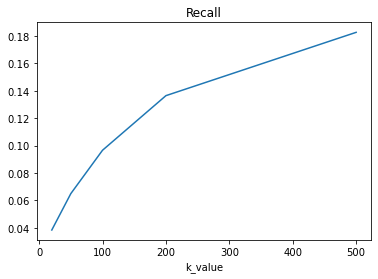

In [38]:
result_values['recall'].plot(title='Recall')

**Recall растет от увеличения К**

**own recommendtions + top-popular дают лучший Recall**

<AxesSubplot:title={'center':'Precision'}, xlabel='k_value'>

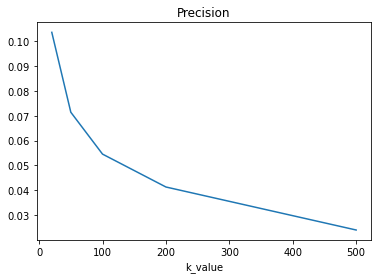

In [40]:
result_values['precision'].plot(title='Precision')

**C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?**

Ответ: Думаю разумным будет число не более 20 даже это при том что при росте К растет Recall, но при этом падает точность Precision, да большее колличество рекомендаций просто утомит пользователя при их просмотре.

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

In [41]:
temp_result

,user_id,actual,owner_rec,item_rec,als_rec,result
0,1,"[836548, 856942, 877391, 933913, 948420, 10368...","[856942, 9297615, 5577022, 877391, 9655212, 11...","[824758, 1007512, 9297615, 5577022, 9803545, 9...","[885290, 1037332, 953539, 898121, 962615, 8569...","[856942, 9297615, 5577022, 877391, 9655212, 11..."
1,2,"[831125, 838136, 852864, 899624, 908649, 91504...","[911974, 7169090, 1076580, 1107760, 1056620, 9...","[1044078, 8090509, 5569845, 819978, 880888, 98...","[5569230, 1029743, 916122, 919534, 8090521, 55...","[911974, 7169090, 1076580, 1107760, 1056620, 9..."
2,3,"[946839, 953476, 1053690]","[1092937, 1008714, 12132312, 1075979, 998206, ...","[1044078, 1113381, 928584, 871061, 999714, 862...","[1044078, 1106523, 8090521, 8090537, 1029743, ...","[1092937, 1008714, 12132312, 1075979, 998206, ..."
3,4,"[947095, 951821, 962229, 990797, 6773204, 1311...","[6391541, 1052294, 891423, 936470, 1137010, 11...","[846764, 846550, 960075, 1111786, 865528, 8980...","[1091383, 1137346, 821741, 891423, 6391541, 90...","[6391541, 1052294, 891423, 936470, 1137010, 11..."
4,5,"[833238, 962199, 1026699, 1003031, 1053530]","[6552318, 1055403, 994577, 1065017, 13073175, ...","[12262778, 6391152, 9420337, 946839, 5591170, ...","[1135573, 1053022, 830245, 13073175, 960421, 8...","[6552318, 1055403, 994577, 1065017, 13073175, ..."
...,...,...,...,...,...,...
2162,2496,"[830156, 844179, 855672, 882138, 883404, 89088...","[872826, 983665, 991546, 1134296, 1006252, 865...","[985999, 5569845, 1041796, 1070702, 1044078, 8...","[844179, 1044078, 899624, 916122, 1004906, 128...","[872826, 983665, 991546, 1134296, 1006252, 865..."
2163,2497,"[822785, 830015, 840361, 883404, 924760, 94281...","[870515, 1117219, 1102207, 1057168, 1135834, 1...","[1043301, 865026, 5569471, 8090521, 1034176, 5...","[12810391, 5569230, 899624, 8090532, 963971, 9...","[870515, 1117219, 1102207, 1057168, 1135834, 1..."
2164,2498,"[852856, 1124729, 13777225, 15740858, 826571, ...","[1076580, 1100379, 5565356, 882810, 968759, 84...","[942778, 901062, 9297461, 908064, 844991, 1102...","[925766, 9676759, 961620, 12326050, 1035676, 9...","[1076580, 1100379, 5565356, 882810, 968759, 84..."
2165,2499,"[939546, 980864, 981880, 1070820, 14077728, 15...","[7168055, 1128395, 6904613, 889989, 830202, 55...","[901062, 5569230, 907631, 1046545, 1004906, 15...","[1029743, 907631, 5568378, 1106523, 5569230, 8...","[7168055, 1128395, 6904613, 889989, 830202, 55..."


In [46]:
df_item = pd.DataFrame({'user_id':temp_result.user_id.values.repeat(50),'item_id':np.concatenate(temp_result.item_rec.values)})


In [47]:
df_als = pd.DataFrame({'user_id':temp_result.user_id.values.repeat(50),'item_id':np.concatenate(temp_result.als_rec.values)})

In [48]:
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2= targets_lvl_2.groupby(['user_id', 'item_id']).head(1)
targets_lvl_2['target'] = 1  # тут только покупки 

targets_lvl_2 = df_item.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')
targets_lvl_2_als = df_als.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')
targets_lvl_2['target'].fillna(0, inplace= True)
targets_lvl_2_als['target'].fillna(0, inplace= True)

In [49]:
targets_lvl_2.target.mean(),targets_lvl_2_als.target.mean()

(0.04186432856483618, 0.016641369845583356)

In [73]:
targets_lvl_2

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,week_day7,item_average_basket_count,item_price,week_day_1_item,week_day_2_item,week_day_3_item,week_day_4_item,week_day_5_item,week_day_6_item,week_day_7_item
0,1,824758,0.0,794.0,GROCERY,National,COLD CEREAL,ALL FAMILY CEREAL,24 OZ,65+,...,0.087647,1.0,4.29,0.103896,0.129870,0.116883,0.159091,0.227273,0.139610,0.123377
1,1,1007512,0.0,2082.0,MEAT-PCKGD,National,HEAT/SERVE,ENTREES,24 OZ,65+,...,0.087647,1.0,2.99,0.132743,0.079646,0.132743,0.181416,0.203540,0.168142,0.101770
2,1,9297615,1.0,1194.0,GROCERY,National,REFRGRATD JUICES/DRNKS,DAIRY CASE 100% PURE JUICE - O,64 OZ,65+,...,0.087647,1.0,3.69,0.126126,0.162162,0.144144,0.108108,0.117117,0.198198,0.144144
3,1,5577022,0.0,1194.0,GROCERY,National,REFRGRATD JUICES/DRNKS,DAIRY CASE 100% PURE JUICE - O,64 OZ,65+,...,0.087647,1.0,3.69,0.121951,0.146341,0.170732,0.158537,0.195122,0.091463,0.115854
4,1,9803545,0.0,1011.0,GROCERY,National,PAPER HOUSEWARES,PLASTIC/HEAVY PAPER PREM PLATE,24 CT,65+,...,0.087647,1.0,3.49,0.109375,0.101562,0.109375,0.171875,0.203125,0.171875,0.132812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108345,2500,1106091,0.0,972.0,GROCERY,National,BAG SNACKS,POTATO CHIPS,12 OZ,NaN,...,0.166952,1.0,3.19,0.098712,0.120172,0.163090,0.248927,0.163090,0.107296,0.098712
108346,2500,833724,0.0,5539.0,GROCERY,National,EGGS,EGGS - LARGE,DZ,NaN,...,0.166952,1.0,2.29,0.133721,0.130814,0.127907,0.177326,0.186047,0.136628,0.107558
108347,2500,1090266,0.0,69.0,GROCERY,Private,SPICES & EXTRACTS,IMITATION EXTRACTS,4 OZ,NaN,...,0.166952,1.0,3.49,0.125000,0.145833,0.187500,0.145833,0.166667,0.166667,0.062500
108348,2500,912704,0.0,5143.0,DRUG GM,National,GREETING CARDS/WRAP/PARTY SPLY,CARDS EVERYDAY,,NaN,...,0.166952,1.0,3.29,0.118421,0.157895,0.168421,0.176316,0.134211,0.136842,0.107895


In [51]:
item_features

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ
...,...,...,...,...,...,...,...
92348,18293142,6384,DRUG GM,National,BOOKSTORE,PAPERBACK BOOKS,
92349,18293439,6393,DRUG GM,National,BOOKSTORE,CHILDRENS LOW END,
92350,18293696,6406,DRUG GM,National,BOOKSTORE,PAPERBACK BEST SELLER,
92351,18294080,6442,DRUG GM,National,BOOKSTORE,PAPERBACK BOOKS,


In [52]:
user_features

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16
...,...,...,...,...,...,...,...,...
796,35-44,U,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,2494
797,45-54,A,75-99K,Homeowner,Unknown,3,1,2496
798,45-54,U,35-49K,Unknown,Single Male,1,None/Unknown,2497
799,25-34,U,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,2498


In [53]:
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

targets_lvl_2_als = targets_lvl_2_als.merge(item_features, on='item_id', how='left')
targets_lvl_2_als = targets_lvl_2_als.merge(user_features, on='user_id', how='left')

In [56]:
data_for_features= data[data.week_no<(data.week_no.max()-val_lvl_2_size_weeks)]


In [57]:
data_for_features

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2193522,601,40879600955,614,62469,1,1.49,3102,0.00,1330,88,0.0,0.0
2193523,601,40879600955,614,65714,1,1.49,3102,0.00,1330,88,0.0,0.0
2193524,601,40879600955,614,111874,1,0.99,3102,-0.60,1330,88,0.0,0.0
2193525,601,40879600955,614,131818,1,1.39,3102,0.00,1330,88,0.0,0.0


In [58]:

total_user_purchase = data_for_features.groupby('user_id').user_id.count()
total_item_purchase = data_for_features.groupby('item_id').item_id.count()

user_average_check = data_for_features.groupby(['user_id','basket_id'])['sales_value'].mean()
user_average_check = user_average_check.groupby('user_id').mean()
user_average_check = dict(user_average_check)


number_of_baskets_per_week = data_for_features.groupby(['user_id','week_no'])['user_id'].count()
number_of_baskets_per_week = number_of_baskets_per_week.groupby('user_id').mean()
number_of_baskets_per_week = dict(number_of_baskets_per_week)

user_average_basket_count = data_for_features.groupby(['user_id','basket_id'])['sales_value'].count()
user_average_basket_count = user_average_basket_count.groupby('user_id').mean()
user_average_basket_count = dict(user_average_check)


days_of_purchase = data_for_features[['user_id','day']].copy()
days_of_purchase['week_day'] = days_of_purchase.day%7
days_of_purchase.loc[days_of_purchase.week_day==0,'week_day'] = 7
days_of_purchase = pd.pivot_table(days_of_purchase,index='user_id',columns='week_day',values = 'day',aggfunc='count',fill_value=0)
days_of_purchase['total'] = total_user_purchase

In [59]:
days_of_purchase

week_day,1,2,3,4,5,6,7,total
user_id,,,,,,,,
1,315,358,179,323,43,104,127,1449
2,21,99,116,83,101,152,45,617
3,199,98,125,66,258,5,119,870
4,30,0,58,1,32,110,53,284
5,9,2,29,14,39,90,36,219
...,...,...,...,...,...,...,...,...
2496,197,106,71,456,399,68,41,1338
2497,270,285,229,221,205,212,293,1715
2498,62,116,100,112,153,130,102,775


In [60]:
targets_lvl_2['user_average_check']=targets_lvl_2.user_id.map(user_average_check)
targets_lvl_2_als['user_average_check']=targets_lvl_2_als.user_id.map(user_average_check)

targets_lvl_2['number_of_baskets_per_week']=targets_lvl_2.user_id.map(number_of_baskets_per_week)
targets_lvl_2_als['number_of_baskets_per_week']=targets_lvl_2_als.user_id.map(number_of_baskets_per_week)

targets_lvl_2['user_average_basket_count']=targets_lvl_2.user_id.map(user_average_basket_count)
targets_lvl_2_als['user_average_basket_count']=targets_lvl_2_als.user_id.map(user_average_basket_count)

for i in range(1,8):
    targets_lvl_2[f'week_day{i}']= targets_lvl_2.user_id.map(days_of_purchase[i]/days_of_purchase['total'])
    targets_lvl_2_als[f'week_day{i}']= targets_lvl_2_als.user_id.map(days_of_purchase[i]/days_of_purchase['total'])
    

item_average_basket_count = data_for_featch.groupby(['item_id','basket_id'])['sales_value'].count()
item_average_basket_count = item_average_basket_count.groupby('item_id').mean()

days_of_purchase_item = data_for_featch[['item_id','day']].copy()
days_of_purchase_item['week_day'] = days_of_purchase_item.day%7
days_of_purchase_item.loc[days_of_purchase_item.week_day==0,'week_day'] = 7
days_of_purchase_item = pd.pivot_table(days_of_purchase_item,index='item_id',columns='week_day',values = 'day',aggfunc='count',   fill_value=0)
days_of_purchase_item['total'] = total_item_purchase


item_price = data_for_featch[['item_id','quantity','sales_value']].copy()
item_price['price'] = item_price.sales_value/item_price.quantity
item_price = item_price.groupby('item_id')['price'].max()

targets_lvl_2['item_average_basket_count']=targets_lvl_2.item_id.map(item_average_basket_count)
targets_lvl_2_als['item_average_basket_count']=targets_lvl_2_als.item_id.map(item_average_basket_count)


targets_lvl_2['item_price']=targets_lvl_2.item_id.map(item_price)
targets_lvl_2_als['item_price']=targets_lvl_2_als.item_id.map(item_price)

for i in range(1,8):
    targets_lvl_2[f'week_day_{i}_item']= targets_lvl_2.item_id.map(days_of_purchase_item[i]/days_of_purchase_item['total'])
    targets_lvl_2_als[f'week_day_{i}_item']= targets_lvl_2_als.item_id.map(days_of_purchase_item[i]/days_of_purchase_item['total'])


In [61]:
targets_lvl_2.loc[targets_lvl_2.item_price==np.inf,'item_price']=0
targets_lvl_2_als.loc[targets_lvl_2_als.item_price==np.inf,'item_price']=0

In [62]:

X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2['target']
X_train_als = targets_lvl_2_als.drop('target', axis=1)
y_train_als = targets_lvl_2_als['target']

In [64]:
train_users = temp_result['user_id'].unique()
result_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_2.columns=['user_id', 'actual']
result_lvl_2 = result_lvl_2[result_lvl_2['user_id'].isin(train_users)]
users_lev_2 = result_lvl_2.user_id.tolist()


In [77]:
result_lvl_2

,user_id,actual
0,1,"[829323, 835108, 836423, 851515, 875240, 87737..."
1,2,"[895388, 8357614, 12301772, 821083, 828106, 83..."
2,3,"[835476, 851057, 872021, 878302, 879948, 90963..."
3,4,"[831063, 883932, 891423, 908283, 954966, 96222..."
4,6,"[850102, 897088, 940806, 1062782, 1078346, 103..."
...,...,...
2189,2496,"[824915, 854920, 861603, 881964, 883404, 89962..."
2190,2497,"[857503, 861792, 896613, 1024306, 5592455, 820..."
2191,2498,"[839243, 846652, 847302, 914190, 951197, 10086..."
2192,2499,"[853354, 882308, 1115160, 826249, 830887, 8334..."


In [81]:
len(users_lev_2)

2032

In [82]:
result_lvl_2['item_sim'] = recommender.get_similar_items_recommendation(users_lev_2,N=5)['similar_recommendation'].tolist()

ValueError: ('Lengths must match to compare', (302807,), (2032,))

In [68]:
score = pd.DataFrame()
score.loc['1_level_item_simular','precision@5'] =\
        result_lvl_2.apply(lambda row : precision_at_k(row['item_sim'],row['actual'],k=5),axis = 1).mean()

KeyError: 'item_sim'

In [ ]:
score

### Финальный проект

Мы уже прошли всю необходимуб теорию для финального проекта. Проект осуществляется на данных из вебинара (данные считаны в начале ДЗ).
Рекомендуем вам **начать делать проект сразу после этого домашнего задания**
- Целевая метрика - precision@5. Порог для уcпешной сдачи проекта precision@5 > 25%
- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно, но крайне желательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и csv файл с рекомендациями 